In [1]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  
colors_list = ["blue", "green", "red", "magenta", "black", "purple", "orange", "brown", "pink"]


Domain, PML, refinement and physical configurations

In [2]:
# Define element size for the mesh refinement
h_i = [0.125,
    0.0625,
    0.0625 / 2,
    0.0625 / 4,
    0.0625 / 8,]

# Domain configuration
Lx = 1. # fluid domain length (without PML)

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 1.   # m/s


# Define the density and velocity functions  
def rho_function(x):    
    return rho_media_1+x[0]*0
def vel_function(x):    
    return vel_media_1+x[0]*0

# PML configuration
pml_thickness = Lx/4
sigma_0 = vel_media_1  #100/Lx

# Solver configuration
tolerance=1e-16
max_it=1000
shift=-5.j
target_imaginary=9
requested_eigenvalues_number = 50 # Number of eigenvalues to compute

Solver configuration and computing

In [3]:
def get_configured_problem(mesh, degrees, sigma_x):
    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof = {}
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global


    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh)

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)


    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(target_imaginary)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )

    solver.setTolerances(tolerance, max_it)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(shift)  
    solver.solve()
    n_eigs_converged_piecewise = solver.getConverged()

    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [4]:
def get_approx_eigenpair(solver, selected_index, Q, V, dof):
    
    # Gets p, v eigenvectors
    p_h = Function(Q, name="p")
    v_h = Function(V, name="v")
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global
    [vrA, viA] = solver.getOperators()[0].getVecs()  # type: ignore
    omega_value = solver.getEigenpair(selected_index, vrA) * (1j)  # type: ignore
    # FEM approximation for the eigenfunction
    p_h.x.petsc_vec.array[:] = vrA[0 : dof["p"]]
    p_h.x.petsc_vec.array[:] = p_h.x.petsc_vec.array[:] / p_h.eval([Lx, 0.0, 0.0], 1)  # normalise
    v_h.x.petsc_vec.array[:] = vrA[dof["p"] :]  
    v_h.x.petsc_vec.array[:] = v_h.x.petsc_vec.array[:] / v_h.eval([Lx, 0.0, 0.0], 1)  # normalise

    return [omega_value, p_h, v_h]  # Return eigenfunction and eigenvalue

In [5]:
# def get_exact_pml_eigenpair(solver, selected_index, Q, V, x_hat, absorption):
#     exact_pml_eigs_function= lambda n: (n * np.pi * vel_media_1 - 1j * absorption) / (Lx + pml_thickness)
#     w=exact_pml_eigs_function(selected_index)

#     p_ex = lambda x: (np.sin((w * x_hat(x, w)) / vel_media_1))  # type: ignore
#     v_ex = lambda x: (1j * np.cos(w * (x_hat(x, w) - x_hat([Lx + pml_thickness, 0, 0], w))))

#     p_ex = Function(Q, name="p_ex")
#     # p_ex.interpolate(p)
#     # p_ex.x.petsc_vec.array[:] = p_ex.x.petsc_vec.array[:] / p_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

#     v_ex = Function(V, name="v_ex")
#     # v_ex.interpolate(v)
#     # v_ex.x.petsc_vec.array[:] = v_ex.x.petsc_vec.array[:] / v_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

#     return [w, p_ex, v_ex]

Singular

In [6]:
# Define singular sigma function
sigma_x_singular=lambda x: conditional(x[0] > Lx, sigma_0 / (Lx + pml_thickness - x[0]), 0.0)
# Initialize lists to store the approximated eigenpairs
approx_singular_P1_P0 = [[0 for _ in range(4)] for _ in range(len(h_i))]
approx_singular_P2_P1 = [[0 for _ in range(4)] for _ in range(len(h_i))]
approx_singular_P3_P2 = [[0 for _ in range(4)] for _ in range(len(h_i))]
approx_singular_P4_P3 = [[0 for _ in range(4)] for _ in range(len(h_i))]

for i,h in enumerate(h_i):
    # Create mesh depending on h
    mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h), [0, Lx + pml_thickness])
    # Define solver for singular PML
    [solver_singular_P1_P0, mesh, Q_P1_P0, V_P1_P0, dof_P1_P0]=get_configured_problem(mesh, [1,0], sigma_x_singular)
    [solver_singular_P2_P1, mesh, Q_P2_P1, V_P2_P1, dof_P2_P1]=get_configured_problem(mesh, [2,1], sigma_x_singular)
    [solver_singular_P3_P2, mesh, Q_P3_P2, V_P3_P2, dof_P3_P2]=get_configured_problem(mesh, [3,2], sigma_x_singular)
    [solver_singular_P4_P3, mesh, Q_P4_P3, V_P4_P3, dof_P4_P3]=get_configured_problem(mesh, [4,3], sigma_x_singular)

    for j in np.arange(0, 4,1):
        # Get the approximated eigenpair
        approx_singular_P1_P0[i][j] = get_approx_eigenpair(solver_singular_P1_P0, j, Q_P1_P0, V_P1_P0, dof_P1_P0)[0]
        approx_singular_P2_P1[i][j] = get_approx_eigenpair(solver_singular_P2_P1, j, Q_P2_P1, V_P2_P1, dof_P2_P1)[0]
        approx_singular_P3_P2[i][j] = get_approx_eigenpair(solver_singular_P3_P2, j, Q_P3_P2, V_P3_P2, dof_P3_P2)[0]
        approx_singular_P4_P3[i][j] = get_approx_eigenpair(solver_singular_P4_P3, j, Q_P4_P3, V_P4_P3, dof_P4_P3)[0]


In [7]:
def group_by_real_part(eigenvalues, tolerance=1):
    groups = []
    for row in eigenvalues:
        for eig in row:
            added = False
            for group in groups:
                if abs(group[0].real - eig.real) < tolerance:
                    group.append(eig)
                    added = True
                    break
            if not added:
                groups.append([eig])
    return groups

groups_P1_P0 = group_by_real_part(approx_singular_P1_P0)
groups_P2_P1 = group_by_real_part(approx_singular_P2_P1)
groups_P3_P2 = group_by_real_part(approx_singular_P3_P2)
groups_P4_P3 = group_by_real_part(approx_singular_P4_P3)

In [8]:
sigma_absorption=pml_thickness*2#((Lx+pml_thickness)**3/3-Lx*(Lx+pml_thickness)**2+Lx**2*(Lx+pml_thickness)-1/3)*sigma_0
get_exact_pml_eigenvalue=lambda n: ((n+1) * np.pi * vel_media_1 - 1j *sigma_absorption) / (Lx + pml_thickness)

exact = [None] * 4
for j in np.arange(0, 4,1):
    exact[j] = get_exact_pml_eigenvalue(j)


Plot of eigenvalues

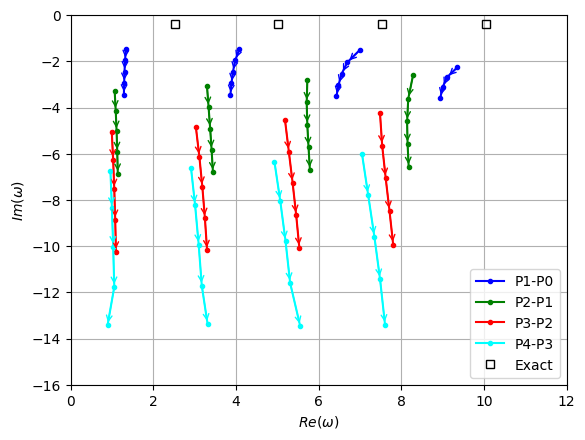

In [9]:
colors_list = ["blue", "green", "red", "cyan", "magenta", "black", "purple", "orange", "brown", "pink"]
eig_list=[]

fig = plt.figure()
ax = plt.gca()
plt.grid(True)

# Función para agregar flechas en la línea
def add_arrows(x, y, color):
    for i in range(len(x)-1):
        ax.annotate('', xy=(x[i+1], y[i+1]), xytext=(x[i], y[i]),
                    arrowprops=dict(arrowstyle="->", color=color))

# P1-P0
x = np.real(groups_P1_P0[1])
y = np.imag(groups_P1_P0[1])
plt.plot(x, y, "x-", color=colors_list[0], label="P1-P0", marker='.')
add_arrows(x, y, colors_list[0])

x = np.real(groups_P1_P0[2])
y = np.imag(groups_P1_P0[2])
plt.plot(x, y, "x-", color=colors_list[0], marker='.')
add_arrows(x, y, colors_list[0])

x = np.real(groups_P1_P0[0])
y = np.imag(groups_P1_P0[0])
plt.plot(x, y, "x-", color=colors_list[0], marker='.')
add_arrows(x, y, colors_list[0])

x = np.real(groups_P1_P0[4])
y = np.imag(groups_P1_P0[4])
plt.plot(x, y, "x-", color=colors_list[0], marker='.')
add_arrows(x, y, colors_list[0])

# P2-P1
x = np.real(groups_P2_P1[0])
y = np.imag(groups_P2_P1[0])
plt.plot(x, y, "x-", color=colors_list[1], label="P2-P1", marker='.')
add_arrows(x, y, colors_list[1])

x = np.real(groups_P2_P1[1])
y = np.imag(groups_P2_P1[1])
plt.plot(x, y, "x-", color=colors_list[1], marker='.')
add_arrows(x, y, colors_list[1])

x = np.real(groups_P2_P1[2])
y = np.imag(groups_P2_P1[2])
plt.plot(x, y, "x-", color=colors_list[1], marker='.')
add_arrows(x, y, colors_list[1])

x = np.real(groups_P2_P1[3])
y = np.imag(groups_P2_P1[3])
plt.plot(x, y, "x-", color=colors_list[1], marker='.')
add_arrows(x, y, colors_list[1])

# P3-P2
x = np.real(groups_P3_P2[0])
y = np.imag(groups_P3_P2[0])
plt.plot(x, y, "x-", color=colors_list[2], label="P3-P2", marker='.')
add_arrows(x, y, colors_list[2])

x = np.real(groups_P3_P2[1])
y = np.imag(groups_P3_P2[1])
plt.plot(x, y, "x-", color=colors_list[2], marker='.')
add_arrows(x, y, colors_list[2])

x = np.real(groups_P3_P2[2])
y = np.imag(groups_P3_P2[2])
plt.plot(x, y, "x-", color=colors_list[2], marker='.')
add_arrows(x, y, colors_list[2])

x = np.real(groups_P3_P2[3])
y = np.imag(groups_P3_P2[3])
plt.plot(x, y, "x-", color=colors_list[2], marker='.')
add_arrows(x, y, colors_list[2])

# P4-P3
x = np.real(groups_P4_P3[0])
y = np.imag(groups_P4_P3[0])
plt.plot(x, y, "x-", color=colors_list[3], label="P4-P3", marker='.')
add_arrows(x, y, colors_list[3])

x = np.real(groups_P4_P3[1])
y = np.imag(groups_P4_P3[1])
plt.plot(x, y, "x-", color=colors_list[3], marker='.')
add_arrows(x, y, colors_list[3])

x = np.real(groups_P4_P3[2])
y = np.imag(groups_P4_P3[2])
plt.plot(x, y, "x-", color=colors_list[3], marker='.')
add_arrows(x, y, colors_list[3])

x = np.real(groups_P4_P3[3])
y = np.imag(groups_P4_P3[3])
plt.plot(x, y, "x-", color=colors_list[3], marker='.')
add_arrows(x, y, colors_list[3])

# Graficar los autovalores exactos como cuadrados sin relleno
x_exact = [eig.real for eig in exact]
y_exact = [eig.imag for eig in exact]
plt.plot(x_exact, y_exact, 's', markerfacecolor='none', markeredgecolor='k', markersize=6, label='Exact')

plt.legend(loc='lower right')
plt.ylim([-16,0])
plt.xlim([0,12])
_ = ax.set_ylabel(r"$Im(\omega)$")
_ = ax.set_xlabel(r"$Re(\omega)$")


Text(0.5, 1.0, 'Pressure Field p_h(x)')

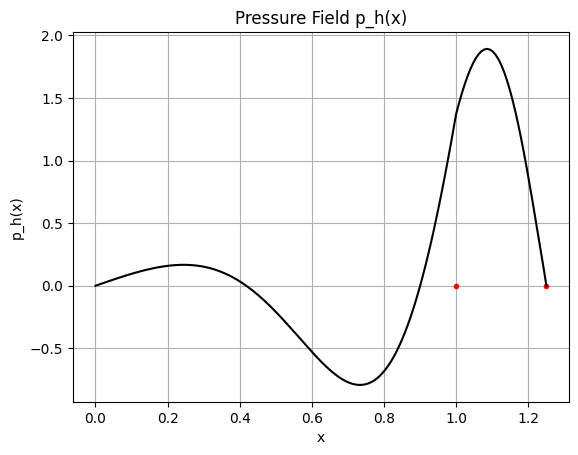

In [10]:
p_h = get_approx_eigenpair(solver_singular_P1_P0, 1, Q_P1_P0, V_P1_P0, dof_P1_P0)[1]
# Subgráfico 2: Representación de p(x)
dofmap = Q_P4_P3.dofmap.index_map.local_range  # Rango local de DoFs
local_coords = mesh.geometry.x[dofmap[0]:dofmap[1], :]  # Coordenadas locales
x_coord = [x[0] for x in local_coords]
plt.plot(1.0, 0, marker='.', color='red', markersize=6, label='Punto especial')
plt.plot(1.25, 0, marker='.', color='red', markersize=6, label='Punto especial')
plt.plot(x_coord, np.real(p_h.x.petsc_vec.array), label="p_h", color="black")


plt.grid(True)
plt.xlabel("x")
plt.ylabel("p_h(x)")
plt.title("Pressure Field p_h(x)")
# plt.legend()
